In [1]:
from myutils import *
from matplotlib.cm import ScalarMappable
from shapely.geometry import LineString
import folium
from folium.plugins import MarkerCluster

pf_cmap = plt.get_cmap('viridis')


In [2]:
# Rutas y nombres de archivos
path_source = '../GeoData/'
path_scenario = 'Results/scenario2017/'
file_scenario = 'puntosEjemplo.gpkg'
layer_scenario = '2017_colapsos'
out = '2017_ejemplo'

In [3]:
# Resultados de la instancia
with open(path_scenario+out+'_results.pkl', 'rb') as f:  
        pf = pickle.load(f)
        f.close()
pf_obj, pf_var, pf_as = pf


# Datos de la instancia
instance_name = path_scenario + out + '.pkl'
with open(instance_name, 'rb') as f:  
        instance = pickle.load(f)
        f.close()
        
origenes = instance['origenes']
destinos = instance['destinos']
origen_i_to_node = instance['origen_i_to_node']
origen_node_to_i = instance['origen_node_to_i']
destino_i_to_num = instance['destino_i_to_num']
destino_num_to_i = instance['destino_num_to_i']
destino_num_to_node = instance['destino_num_to_node']
destino_node_to_num = instance['destino_node_to_num']
capacidades = instance['capacidades']
demanda = instance['demanda']
matriz_OD = instance['matriz_OD']
rutas = instance['rutas']      

In [4]:
# Carga las capas complementarias
cdmx_layer = gpd.read_file(path_source+'Polygons.gpkg', layer='CDMX', encoding='utf-8')
alcaldias_layer = gpd.read_file(path_source+'Polygons.gpkg', layer='alcaldias', encoding='utf-8')
regiones_layer = gpd.read_file(path_source+'Polygons.gpkg', layer='regiones', encoding='utf-8')
riesgo_layer = gpd.read_file(path_source+'Polygons.gpkg', layer='riesgo', encoding='utf-8')

# Carga los hospitales
hospitales = gpd.read_file(path_source + 'Points.gpkg', layer = 'hospitales')
hospitales_f = hospitales[hospitales['camas_en_a']>=10].explode(index_parts=True)
hospitales_f = hospitales_f.reset_index(drop=True)
hospitales_f.rename(columns = {'nombre_d_6':'nombre'}, inplace = True)

# Carga los refugios
albergues = gpd.read_file(path_source + 'Points.gpkg', layer = 'refugios')

# Carga los centros de acopio
acopios = gpd.read_file(path_source + 'Points.gpkg', layer = 'acopio')


In [13]:
# Carga las pltbs
pltbs = gpd.read_file(path_source + 'PLTBs.gpkg', layer = 'PLTBs_nodes')

# Serializa los datos de tipo lista
pltbs['streets'] = pltbs['streets'].apply(json.loads)
pltbs['streets'] = pltbs['streets'].apply(lambda x: list(set(x)))
pltbs['oneway'] = pltbs['oneway'].apply(json.loads)
pltbs['length'] = pltbs['length'].apply(json.loads)
pltbs['capacity'] = pltbs['capacity'].apply(json.loads)
pltbs['grouped'] = pltbs['grouped'].apply(json.loads)
pltbs_grupos= [item for sublist in [ i for i in pltbs['grouped']] for item in sublist]
pltbs_nodos = list(pltbs['node'])
pltbs.set_index('node', inplace = True)

pltbs.rename(columns = {'t_capacity':'Capacidad total'}, inplace = True)
pltbs.rename(columns = {'t_length':'Longitud total'}, inplace = True)
pltbs.rename(columns = {'merged':'Segmentos de vialidad'}, inplace = True)
pltbs.rename(columns = {'streets':'Vialidades'}, inplace = True)

#pltbs = pltbs[['Capacidad total', 'Longitud total', 'Segmentos de vialidad', 'Vialidades', 'lat', 'lon', 'geometry']] 

# Carga los colapsos
colapsos = gpd.read_file(path_scenario+file_scenario, layer = layer_scenario)
colapsos.set_index('num', inplace = True)


In [ ]:
nodos = gpd.read_file(path_source + 'graph_transport.gpkg', layer = 'nodes')
nodos.set_index('osmid', inplace = True)
calles = gpd.read_file(path_source + 'graph_transport.gpkg', layer = 'edges')

## Grafica el frente de Pareto

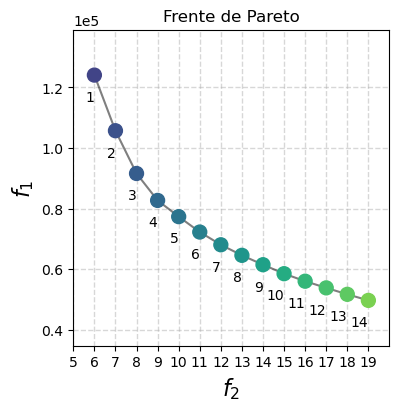

: 

In [62]:
color_in_cmap = [pf_cmap((i/(len(pf_obj)-1))*(0.8-0.2) + 0.2) for i in range(len(pf_obj)) ]

fig,ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)

ax.plot(pf_obj[:,1], pf_obj[:,0], c='k', alpha=0.5)
ax.scatter(pf_obj[:,1], pf_obj[:,0], s=100,
           c=color_in_cmap, zorder=3)


max_num_bases = np.ceil(len(demanda)/2)
max_f1, max_f2 = [len(demanda)*9000, max_num_bases + 1]

ax.set_box_aspect(1)
ax.set_xlabel('$f_2$',fontsize=16)
ax.set_ylabel('$f_1$',fontsize=16)
ax.set_title('Frente de Pareto')
ax.set_xlim([min(pf_obj[:,1])-1,max(pf_obj[:,1])+1])
ax.set_ylim([min(pf_obj[:,0])-15000,max(pf_obj[:,0])+15000])
ax.grid(True, alpha=0.5, linestyle='--', linewidth=1, zorder=0)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
step = [1,2][(max_f2 > 20)*1]
ax.set_xticks([i for i in range(int(min(pf_obj[:,1])-1),int(max_f2),step)])
for i in range(len(pf_obj)):
    ax.annotate(str(i+1), (pf_obj[i,1], pf_obj[i,0]-5000), fontsize=10, zorder=4, va='top', ha='right')

# Añadimos una barra de colores
#sm = ScalarMappable(cmap=pf_cmap, norm=plt.Normalize(0, 499))
#sm.set_array([])  # Establecemos un array vacío

# Agregamos la barra de colores al eje
#fig.colorbar(sm, ax=ax, label='Generación', location='bottom',shrink=0.8, pad=0.1)
fig.savefig(path_scenario+out+'_PF.png', dpi=600, bbox_inches='tight')

In [25]:
vis_preview = False
save_preview = False
bases_cmap = plt.get_cmap('gist_rainbow')

reps = [0,len(pf_obj)//2, len(pf_obj)-1]
reps = [i for i in range(len(pf_obj))]
#reps = [13]

            
res = get_sol_info(reps, pf_as, pltbs, colapsos, nodos, origen_i_to_node, origen_node_to_i,
                 destino_i_to_num, destino_num_to_node, demanda, rutas, bases_cmap, out, path_scenario,
                 cdmx_layer, calles, alcaldias_layer, vis_preview = False, save_preview = False, seed_colors= 788284517)



In [29]:
sol = 7
gdf_rutas = copy(res['rutas'][sol])
gdf_lineas = copy(res['lineas'][sol])
gdf_destinos = copy(res['destinos'][sol])
gdf_bases = copy(res['bases'][sol])
gdf_info = copy(res['info'])


def rgba2hex(rgba):
    # Asegurarse de que los valores estén en el rango correcto (0.0 - 1.0)
    rgba = [min(1, max(0, channel)) for channel in rgba[:3]]  # Ajustar los valores RGB a estar entre 0 y 1
    
    # Convertir los valores RGB a valores hexadecimales
    hex_color = '#{:02x}{:02x}{:02x}'.format(int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255))
    
    return hex_color

grupos = gdf_rutas['grupo'].unique()
colores_rutas = [rgba2hex(bases_cmap(i/len(grupos))) for i in range(len(grupos))]
    
      
#gdf_bases = gdf_bases[['grupo','Asignados','color_grupo','geometry']]
    
 
tiles = {'monoLight': f"https://api.mapbox.com/styles/v1/jmmorph/cln3g3fze06q801qiavzu96hz/tiles/256/{{z}}/{{x}}/{{y}}@2x?access_token=",
        'monoDark': f"https://api.mapbox.com/styles/v1/jmmorph/clms73x09059301qid5sc3s1p/tiles/256/{{z}}/{{x}}/{{y}}@2x?access_token="}

try:
    # Api key de TomTom
    with open('../GeoData/' + 'mapbox_apikey.txt', 'r') as f:
        apiKey = f.read()
        f.close()
except:
    print('No se pudo leer el archivo con la API key de mapbox')
    print('se debe crear un archivo "mapbox_apikey.txt" en la carpeta GeoData')
    

tiles_default = folium.TileLayer(
    tiles=tiles['monoLight']+apiKey,
    attr='Mapbox',
    name='Monochrome Light',
)

m = folium.Map(location=[19.3, -99.1332], zoom_start=12,tiles=tiles_default)

folium.TileLayer(
    tiles=tiles['monoDark']+apiKey,
    attr='Mapbox',
    name='Monochrome Dark',
).add_to(m)

alcaldias_layer.explore(m=m, name='Alcaldías', style_kwds = dict(style_function=lambda x: {'fillColor': 'none', 'color': 'black', 
                                                     'weight': 0.5, 'fillOpacity': 0, 'dashArray': '5, 5'}))

riesgo_layer[['intensidad','geometry']].explore(m=m, name='Riesgo sísmico', column='intensidad',legend=True, cmap='Reds',
                     style_kwds = dict(style_function=lambda x: {'weight': 0.5, 'fillOpacity': 0.2}),  show=False)

regiones_layer[['region','encargado','geometry']].explore(m=m, name='Regiones', column='region',legend=True, highlight=False, cmap='rainbow',
                        style_kwds = dict(style_function=lambda x: {'opacity':0.3,'weight': 5, 'fillOpacity': 0.05,}))

icono_html2 = folium.Icon(icon='cloud', prefix='fa', color='blue')


l_groups = [[] for _ in range(len(gdf_bases))]
for i in gdf_bases.index:
    

    # Crear un grupo (FeatureGroup)
    l_groups[i] = folium.FeatureGroup(name='Grupo '+str(i+1))
    
    popup_content = f"<div style='font-size: 16px;'>" 
    popup_content += f"<strong>Grupo:</strong> {i+1}<br>"
    popup_content += f"<strong>Vialidades:</strong> {gdf_bases.loc[i]['Vialidades']}<br>"
    popup_content += f"<strong>Focos atendidos:</strong> {gdf_bases.loc[i]['Asignados']}<br>"
    popup_content += f"<strong>Punto más lejano:</strong> {gdf_rutas[gdf_rutas['grupo']==i]['distancia'].idxmax()}<br>"
    popup_content += f"<strong>Ruta más larga:</strong> {gdf_rutas[gdf_rutas['grupo']==i]['distancia'].max()}<br>"
    popup_content += f"<strong>Ambulancias:</strong> {gdf_bases.loc[i]['Ambulancias']}<br>"
    popup_content += f"<strong>Capacidad:</strong> {int(gdf_bases.loc[i]['Capacidad total'])}<br>"
    popup_content += f"</div>"  
    
    folium.Marker(
        location=[gdf_bases.loc[i]['lat'], gdf_bases.loc[i]['lon']],
        popup=folium.Popup(popup_content, max_width=300),
        icon=folium.Icon(icon='star-of-life', prefix='fa', color='blue', icon_color='white')
    ).add_to(l_groups[i])
    
    
    # Iterar sobre los destinos del grupo
    destinos_grupo = gdf_destinos[gdf_destinos['grupo']==i]
    
    for idx, row in destinos_grupo.iterrows():  
        
        # Obtener las coordenadas del punto
        lat = row['lat']  # Reemplaza 'latitud' y 'longitud' con tus nombres de columnas
        lon = row['lon']
        
        popup_content = f"<div style='font-size: 16px;'>" 
        popup_content += f"<strong>Punto:</strong> {idx}<br>"
        popup_content += f"<strong>Victimas:</strong> {destinos_grupo.loc[idx]['victimas']}<br>"
        popup_content += f"<strong>Demanda:</strong> {destinos_grupo.loc[idx]['demanda']}<br>"
        popup_content += f"<strong>Grupo:</strong> {destinos_grupo.loc[idx]['grupo']}<br>"
        popup_content += f"<strong>Alcalía:</strong> {destinos_grupo.loc[idx]['alcaldia']}<br>"
        popup_content += f"<strong>Colonia:</strong> {destinos_grupo.loc[idx]['colonia']}<br>"
        popup_content += f"<strong>CP:</strong> {destinos_grupo.loc[idx]['codigo_pos']}<br>"
        popup_content += f"<strong>Latitud:</strong> {destinos_grupo.loc[idx]['lat']}<br>"
        popup_content += f"<strong>Longitud:</strong> {destinos_grupo.loc[idx]['lon']}<br>"
        popup_content += f"<strong>Promedio de ocupantes:</strong> {destinos_grupo.loc[idx]['prom_ocup']}<br>"
        popup_content += f"</div>"  

        
        icono_html = folium.DivIcon(
                        html=f'<div style="font-size: 24px; color: {colores_rutas[i]};">✘</div>',  # Código HTML para un diamante
                        icon_anchor=(12, 12))
        
        # Agregar un marcador con ícono personalizado al mapa
        folium.Marker([lat, lon], icon= icono_html,
                        popup=folium.Popup(popup_content, max_width=300)).add_to(l_groups[i])  # 'Nombre' es el dato que aparecerá en el popup

    
        
    # Agregar las rutas del grupo
    rutas_grupo = copy(gdf_rutas[gdf_rutas['grupo']==i])
    rutas_grupo['grupo'] = i+1
    rutas_grupo.drop(columns=['color_grupo'], inplace=True)
    rutas_grupo.explore(m=l_groups[i],color=[colores_rutas[i] for _ in range(len(rutas_grupo))],
                        name='Rutas',popup=['grupo','destino','distancia'],
                        style_kwds = dict(style_function=lambda x: {'opacity':0.8,'weight': 3}))
    
    # Añadir el grupo al mapa
    l_groups[i].add_to(m)

# Crear un MarkerCluster para agrupar los marcadores de hospitales
hospital_cluster = MarkerCluster(name='Hospitales',show=False)
# Iterar sobre el GeoDataFrame y agregar hospitales al MarkerCluster
for idx, row in hospitales_f.iterrows():
    popup_content = f"<div style='font-size: 16px;'>" 
    popup_content += f"<strong>Nombre:</strong> {hospitales_f.loc[idx]['nombre']}<br>"
    popup_content += f"<strong>Institución:</strong> {hospitales_f.loc[idx]['nombre_d_3']}<br>"
    popup_content += f"<strong>Camas en área de hospital:</strong> {int(hospitales_f.loc[idx]['camas_en_a'])}<br>"
    popup_content += f"<strong>Alcaldía:</strong> {hospitales_f.loc[idx]['alcaldia']}<br>"
    popup_content += f"<strong>Calle:</strong> {hospitales_f.loc[idx]['vialidad']}<br>"
    popup_content += f"<strong>Número:</strong> {hospitales_f.loc[idx]['numero_ext']}<br>"
    popup_content += f"<strong>Nivel de atención:</strong> {hospitales_f.loc[idx]['nivel_aten']}<br>"
    
    popup_content += f"</div>"  
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=folium.Popup(popup_content, max_width=300),
        icon=folium.Icon(color='red', icon='circle-h', prefix='fa', icon_color='white')
    ).add_to(hospital_cluster)
# Agregar el MarkerCluster al mapa
hospital_cluster.add_to(m)


acopios_grupo = folium.FeatureGroup(name='Centros de acopio',show=False)

for i in acopios.index:
    
    popup_content = f"<div style='font-size: 16px;'>" 
    popup_content += f"<strong>Nombre:</strong> {acopios.loc[i]['nombre']}<br>"
    popup_content += f"<strong>Alcaldía:</strong> {acopios.loc[i]['alcaldia']}<br>"
    popup_content += f"<strong>Región:</strong> {acopios.loc[i]['region']}<br>"
    popup_content += f"</div>"  
    
    folium.Marker(
        location=[acopios.loc[i]['lat'], acopios.loc[i]['lon']],
        popup=folium.Popup(popup_content, max_width=300),
        icon=folium.Icon(icon='apple-whole', prefix='fa', color='green', icon_color='white')
    ).add_to(acopios_grupo)
acopios_grupo.add_to(m)



albergues_grupo = folium.FeatureGroup(name='Refugios',show=False)
for i in albergues.index:
 
    popup_content = f"<div style='font-size: 16px;'>" 
    popup_content += f"<strong>Colonia:</strong> {albergues.loc[i]['colonia']}<br>"
    popup_content += f"<strong>Alcaldía:</strong> {albergues.loc[i]['alcaldia']}<br>"
    popup_content += f"<strong>Región:</strong> {albergues.loc[i]['region']}<br>"
    popup_content += f"<strong>Dirección:</strong> {albergues.loc[i]['calle_y_nu']}<br>"
    popup_content += f"<strong>Capacidad:</strong> {albergues.loc[i]['cap_alberg']}<br>"
    popup_content += f"</div>"  
    
    folium.Marker(
        location=[albergues.loc[i]['lat'], albergues.loc[i]['lon']],
        popup=folium.Popup(popup_content, max_width=300),
        icon=folium.Icon(icon='tent', prefix='fa', color='orange', icon_color='white')
    ).add_to(albergues_grupo)
albergues_grupo.add_to(m)


# Controlador de capas
folium.LayerControl().add_to(m)
m.save(path_scenario + 'solucion.html')
m

    

In [ ]:
gdf_info

,f1,f2,rmax,rmean,aislados,bmin,bmax
Sol,,,,,,,
1,124065.2,6,7904.6,3264.9,1,2,16
2,105696.9,7,7800.3,2781.5,1,2,13
3,91577.8,8,6107.8,2409.9,1,2,8
4,82685.1,9,6258.1,2175.9,1,2,7
5,77329.4,10,6258.1,2035.0,2,2,7
6,72245.0,11,5013.1,1901.2,4,3,7
7,68039.6,12,4907.8,1790.5,5,3,7
8,64555.3,13,4907.8,1698.8,6,2,7
9,61456.4,14,4907.8,1617.3,7,2,7
